In [25]:

import librosa
import soundfile as sf
import numpy as np
from scipy.fftpack import fft, ifft
import matplotlib.pyplot as plt
from pathlib import Path

print("Библиотеки успешно импортированы!")

Библиотеки успешно импортированы!


In [30]:
from pathlib import Path

def load_and_save(path_to_data: Path | str, path_to_save: Path | str) -> tuple[list[Path], Path]:
    folder = Path(path_to_data).resolve()
    print(f"Папка с данными: {folder}")  # Проверка пути
    folder_to_save = Path(path_to_save).resolve()
    folder_to_save.mkdir(parents=True, exist_ok=True)

    paths = list(folder.rglob("*.wav"))
    print(f"Найдено {len(paths)} файлов для обработки.")
    return paths, folder_to_save

input_folder = "./Recordings"   # Убедитесь, что это относительный путь
output_folder = "./Result"

files, folder_to_save = load_and_save(input_folder, output_folder)

Папка с данными: C:\Users\Anton\.vscode\gpo\Recordings
Найдено 3 файлов для обработки.


In [31]:
def estimate_noise_power(signal, sample_rate, duration=0.1):
    num_samples = int(sample_rate * duration)
    noise_estimate = np.mean(np.abs(signal[:num_samples]) ** 2)
    return noise_estimate

def wiener_filter(signal, sample_rate, noise_power_ratio=0.5):
    noise_power = estimate_noise_power(signal, sample_rate)
    signal_fft = fft(signal)
    signal_power = np.abs(signal_fft) ** 2

    wiener_coeffs = signal_power / (signal_power + noise_power * noise_power_ratio)
    filtered_signal_fft = signal_fft * wiener_coeffs
    filtered_signal = np.real(ifft(filtered_signal_fft))
    return filtered_signal

In [37]:
import numpy as np
import librosa
import soundfile as sf
import pywt
from pathlib import Path

# Вейвлетовое шумоподавление
def wavelet_denoise(signal, wavelet='db4', level=None, threshold_multiplier=5.0):
    """
    Вейвлетовое шумоподавление с настраиваемым порогом.

    :param signal: Входной сигнал.
    :param wavelet: Тип вейвлета (например, 'db4').
    :param level: Уровень декомпозиции.
    :param threshold_multiplier: Коэффициент усиления порога.
    :return: Очищенный сигнал.
    """
    if level is None:
        level = pywt.dwt_max_level(len(signal), pywt.Wavelet(wavelet).dec_len)

    coeffs = pywt.wavedec(signal, wavelet, level=level)

    threshold = threshold_multiplier * np.std(coeffs[-1]) * np.sqrt(2 * np.log(len(signal)))

    coeffs_threshold = [pywt.threshold(c, value=threshold, mode='soft') for c in coeffs]

    return pywt.waverec(coeffs_threshold, wavelet)

def process_files_wavelet_denoise(files: list[Path], path_to_data: Path | str, path_to_save: Path | str) -> None:
    path_to_data = Path(path_to_data).resolve()
    path_to_save = Path(path_to_save).resolve()

    for file in files:
        print(f"\nОбработка файла: {file.name}")
        y, sr = librosa.load(file, sr=None)

        reduced_noise = wavelet_denoise(y, wavelet='db4', level=5)

        relative_path = file.relative_to(path_to_data)
        output_path = path_to_save / relative_path
        sf.write(output_path, reduced_noise, sr)
        print(f"Файл \"{file.name}\" успешно обработан и сохранён в {output_path}")

input_folder = "./Recordings"   # Убедитесь, что это относительный путь
output_folder = "./Result"

if not files:
    print("Нет файлов для обработки!")
else:
    process_files_wavelet_denoise(files, input_folder, output_folder)


Обработка файла: ГПО 1.wav
Файл "ГПО 1.wav" успешно обработан и сохранён в C:\Users\Anton\.vscode\gpo\Result\ГПО 1.wav

Обработка файла: ГПО 4.wav
Файл "ГПО 4.wav" успешно обработан и сохранён в C:\Users\Anton\.vscode\gpo\Result\ГПО 4.wav

Обработка файла: ГПО 8.wav
Файл "ГПО 8.wav" успешно обработан и сохранён в C:\Users\Anton\.vscode\gpo\Result\ГПО 8.wav


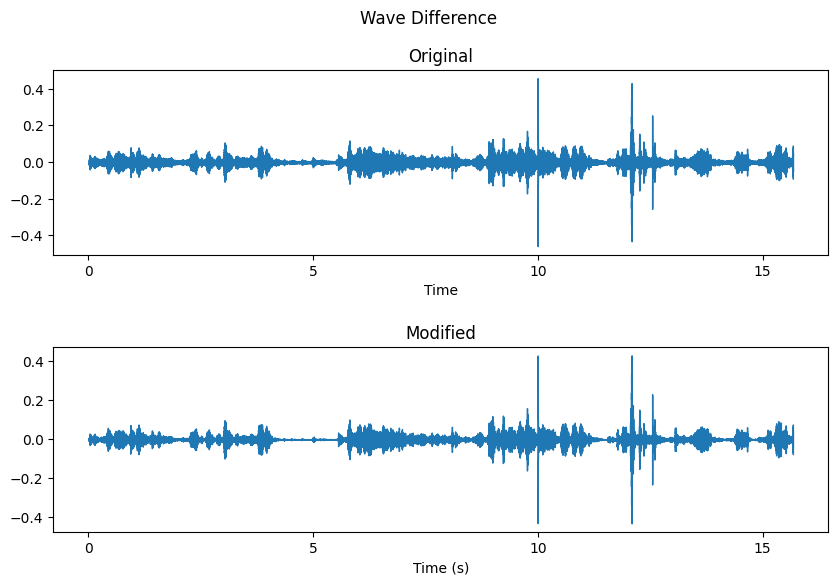

In [39]:
# Ячейка 5: Визуализация результатов
def showDifference_wave(file1, file2):
    y, sr = librosa.load(file1, sr=None)
    y1, sr1 = librosa.load(file2, sr=None)
    fig, axs = plt.subplots(2, figsize=(10, 6), gridspec_kw={'hspace': 0.5})
    fig.suptitle('Wave Difference')
    librosa.display.waveshow(y, sr=sr, ax=axs[0])
    axs[0].set_title("Original")
    librosa.display.waveshow(y1, sr=sr1, ax=axs[1])
    axs[1].set_title("Modified")
    plt.xlabel("Time (s)")
    plt.show()

original_file = Path(input_folder) / "ГПО 1.wav"
processed_file = Path(output_folder) / "ГПО 1.wav"

if processed_file.exists():
    showDifference_wave(original_file, processed_file)
else:
    print(f"Обработанный файл \"{processed_file}\" не найден.")

Визуализация спектральных различий для файла: ГПО 1.wav


C:\Users\Anton\AppData\Local\Temp\ipykernel_13100\1532820184.py:16: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  D = librosa.amplitude_to_db(librosa.stft(y), ref=np.max)
C:\Users\Anton\AppData\Local\Temp\ipykernel_13100\1532820184.py:20: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  D1 = librosa.amplitude_to_db(librosa.stft(y1), ref=np.max)


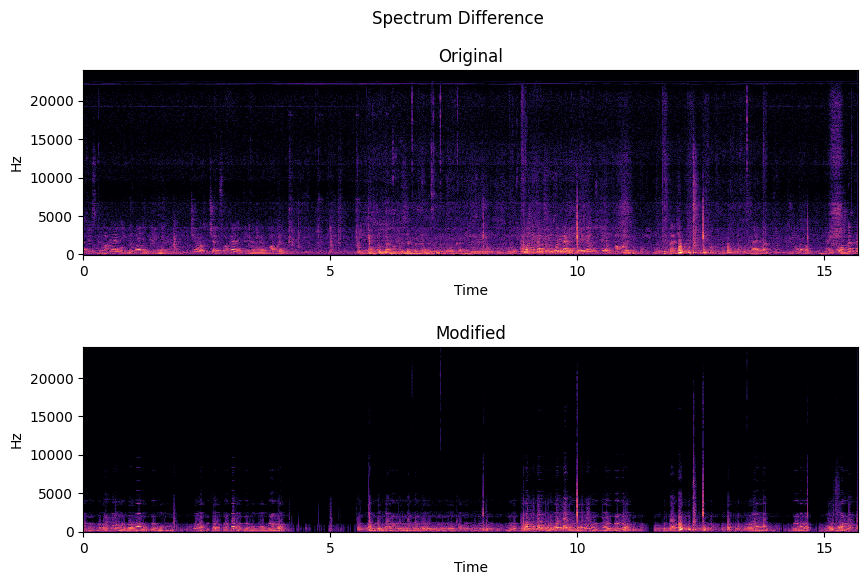

In [40]:
# Ячейка 5: Визуализация спектральных различий

import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
from pathlib import Path

def showDifference_spectrum(file1, file2):
    y, sr = librosa.load(file1, sr=None)
    y1, sr1 = librosa.load(file2, sr=None)

    fig, axs = plt.subplots(2, figsize=(10, 6), gridspec_kw={'hspace': 0.5})
    fig.suptitle('Spectrum Difference')

    D = librosa.amplitude_to_db(librosa.stft(y), ref=np.max)
    axs[0].set_title("Original")
    librosa.display.specshow(D, sr=sr, x_axis="time", y_axis="linear", ax=axs[0])

    D1 = librosa.amplitude_to_db(librosa.stft(y1), ref=np.max)
    axs[1].set_title("Modified")
    librosa.display.specshow(D1, sr=sr1, x_axis="time", y_axis="linear", ax=axs[1])

    plt.show()

# Укажите пути к файлам
original_file = Path("./Recordings") / "ГПО 1.wav"
processed_file = Path("./Result") / "ГПО 1.wav"

if processed_file.exists():
    print(f"Визуализация спектральных различий для файла: {original_file.name}")
    showDifference_spectrum(original_file, processed_file)
else:
    print(f"Обработанный файл \"{processed_file}\" не найден.")